In [1]:
from ipynb.fs.full.Introduction import *
from tqdm import tqdm
import time

## Dataset

We generate random networks via a Stochastic Block Model (SBM). Given probability matrix $P\in{}R^{kxk}$ and $k$ clusters, a Stochastic Block Model defines the network wherein $p(e_{ij})=P_{c_{i},c_{j}}$ for cluster assignments $c_{i},c_{j}$. This allows us to model a wide range of topologies [3,12]. As a starting point, we produce a synthetic dataset of 3000 highly-connected SBMs with cluster size $n\sim{}Unif(50,100)$, $k=5$, and $P\sim{}Unif(\frac{1}{n},\frac{10}{n})$. Features are uninformative, being the vector $\vec{1}\in{}R^{|V|}$, and are equivalent to a single bias term. $66\%-33\%$ train-test split.

In [2]:
num_graphs = 3000
d = []

for _ in range(num_graphs):
    n = torch.randint(50,100,(5,))
    p = 1/n + (10/n - 1/n) * torch.rand((5,5))
    p = .5 * (p + p.T)
    x,edges = torch.randn((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
    adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

    d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))

100%|██████████| 3000/3000 [00:21<00:00, 142.61it/s]


We examine the relationship between the density,$\frac{|E|}{|V|^{2}}$, of an SBM and the ratio of its two largest eigenvalues, $\frac{|\lambda{}_{2}|}{|\lambda{}_{1}|}$. This latter quantity determines the rate of convergence of $A\vec{x}$ to the dominant eigenvector $\vec{v_{1}}$. If $||\vec{x}||=1$, then we have:

$$\vec{x} = (x\cdot{}v_{1})v_{1} + (x\cdot{}v_{2})v_{2} + ... + (x\cdot{}v_{n})v_{n}$$

$$A^{k}\vec{x} = \lambda_{1}^{k}(x\cdot{}v_{1})v_{1} + \lambda_{2}^{k}(x\cdot{}v_{2})v_{2} + ... + \lambda_{n}^{k}(x\cdot{}v_{n})v_{n}$$

For sufficiently large $k$,

$$A^{k}\vec{x} \approx{} \lambda_{1}^{k}(x\cdot{}v_{1})v_{1} + \lambda_{2}^{k}(x\cdot{}v_{2})v_{2} $$
$$=\lambda_{1}^{k}(x\cdot{}v_{1})(v_{1} + (\frac{\lambda_{2}}{\lambda_{1}})^{k}(\frac{x\cdot{}v_{2}}{x\cdot{}v_{1}})v_{2})$$
As $|\lambda_{2}|\leq{}|\lambda_{1}|$, the magnitude of the second term (i.e: the approximation error) will decay according to $(\frac{|\lambda_{2}|}{|\lambda_{1}|})^{k}$, or $\frac{|\lambda_{2}|}{|\lambda_{1}|}$ per iteration.


In [26]:
num_samples = 100
p_range = torch.logspace(-2,1,100)
density = []
eig_ratio = []

for p in p_range:
    for _ in range(num_samples):
        n = torch.randint(50,100,(5,))
        if p<1:
            P = 1/n + ((p-1)/n) * torch.rand((5,5))
        else:
            P = p/n + ((1-p)/n) * torch.rand((5,5))
        P = .5 * (P + P.T) 
        x,edges = torch.randn((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,P))[0]
        adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

        density.append(torch_sparse.sum(adj)/(adj.size(0)*adj.size(1)))
        
        vals = torch.sort(torch.norm(torch.eig(adj.to_dense())[0],dim=1))
        eig_ratio.append(vals[0][-2]/vals[0][-1])

100%|██████████| 100/100 [05:39<00:00,  3.39s/it]


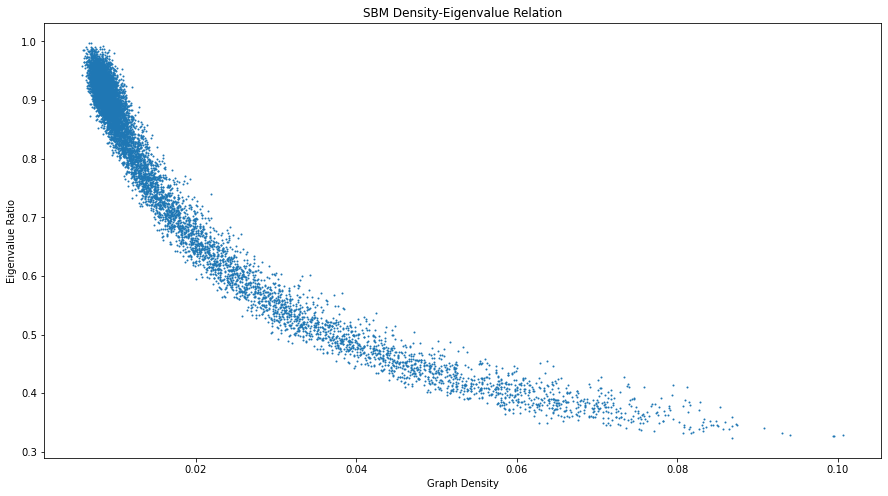

In [33]:
plt.figure(figsize=(15,8))
plt.scatter(density,eig_ratio,s=1)
plt.xlabel('Graph Density')
plt.ylabel('Eigenvalue Ratio')
plt.title('SBM Density-Eigenvalue Relation');

In [28]:
print("Correlation Coefficient: {}".format(np.corrcoef(density,eig_ratio)[1,0]))

Correlation Coefficient: -0.9289814715753415


For reference, the average density of our dataset is around $.08$, so $E[\frac{|\lambda_{2}|}{|\lambda_{1}|}]\approx{}.4$

## Degree Centrality

As a sanity check, we first trained our GCNs on degree centrality.

$$d_{degree}(v_{i}) = \sum_{j\in{}N_{i}^{1}}w_{ij}$$
GraphConv trivially reduces to degree centrality, so this will provide us a good performance benchmark. Optimal weights are given by $\Theta_{1}^{0}\rightarrow{}0, \Theta^{0}_{2}\rightarrow{}1$ and $\Theta_{1}^{q}\rightarrow{}x, \Theta^{q}_{2}\rightarrow{}0$ for $q>0$. A one-layer EdgeConv model can also learn an exact solution, which occurs for $\Theta{}^{0}\rightarrow{}1$. No such solution exists for $l>0$  unless all nodes are self-looping, which is not the case for SBMs. 

We present our results for weighted-undirected, weighted-directed, and unweighted-undirected networks. Weights are drawn from a standard normal distribution and mapped onto the existing edges of our dataset; in the directed case, we simply do not symmetricize them. 


### Unweighted, Undirected

In [3]:
for idx,G in enumerate(d):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    y = torch_sparse.sum(adj,dim=1)
    G.y = y
    d[idx] = G
    
train,test = d[:2000],d[2000::]

train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

100%|██████████| 3000/3000 [00:00<00:00, 3891.04it/s]


In [4]:
torch.manual_seed(0)

Graph = GraphConv(1,32,1,1).cuda()
Edge = EdgeConv(1,32,1,1).cuda()

graph_metrics = train_loop(Graph,train_loader,test_loader,100,lr=1e-3)
torch.cuda.empty_cache()
edge_metrics = train_loop(Edge,train_loader,test_loader,100,lr=1e-3)
torch.cuda.empty_cache()

2241: 100%|██████████| 100/100 [04:03<00:00,  2.43s/it]


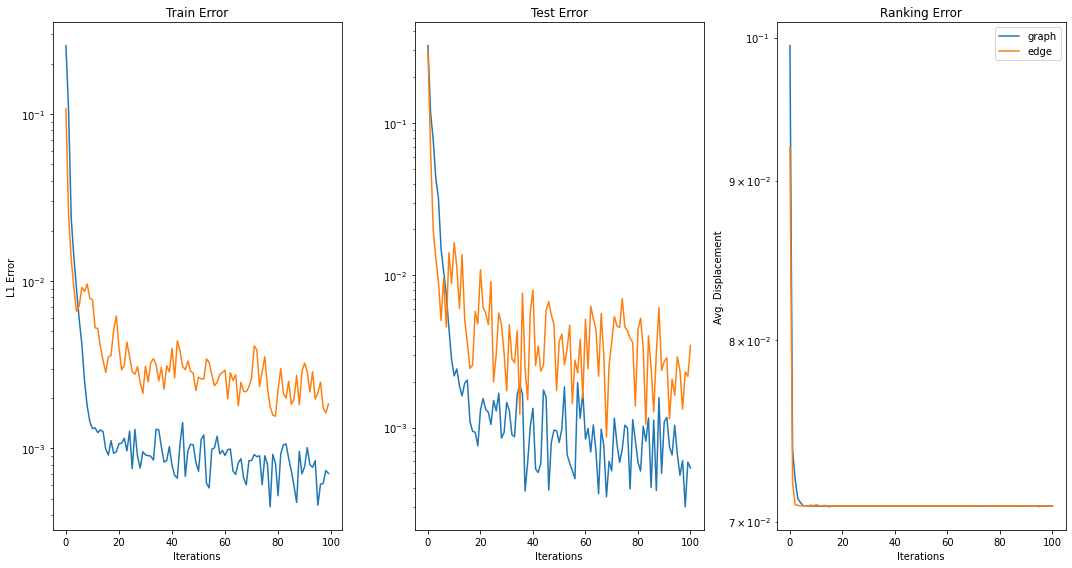

In [5]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.semilogy(graph_metrics[0])
plt.semilogy(edge_metrics[0])
plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
plt.semilogy(graph_metrics[1])
plt.semilogy(edge_metrics[1])
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
plt.semilogy(graph_metrics[2],label='graph')
plt.semilogy(edge_metrics[2],label='edge')
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

### Weighted, Undirected

In [6]:
for idx,G in enumerate(d):
    
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=torch.randn(G.edge_index[0].shape))
    adj = adj.to_dense()
    adj = .5 * (adj + adj.T)
    adj = torch_sparse.SparseTensor.from_dense(adj)
    G.edge_weight = adj.coo()[2]
    y = torch_sparse.sum(adj,dim=1)
    G.y = y
    d[idx] = G
    
train,test = d[:2000],d[2000::]

train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

100%|██████████| 3000/3000 [00:04<00:00, 632.16it/s]


In [7]:
torch.manual_seed(0)

Graph = GraphConv(1,32,1,1).cuda()
Edge = EdgeConv(1,32,1,1).cuda()

graph_metrics = train_loop(Graph,train_loader,test_loader,100,lr=1e-3)
torch.cuda.empty_cache()
edge_metrics = train_loop(Edge,train_loader,test_loader,100,lr=1e-3)
torch.cuda.empty_cache()

2241: 100%|██████████| 100/100 [04:04<00:00,  2.45s/it]


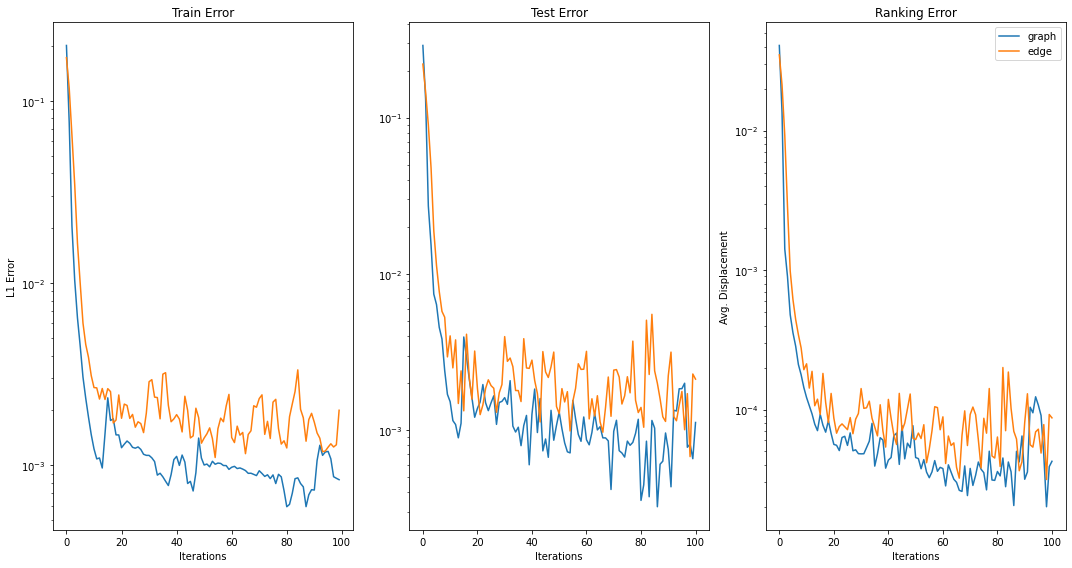

In [8]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.semilogy(graph_metrics[0])
plt.semilogy(edge_metrics[0])
plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
plt.semilogy(graph_metrics[1])
plt.semilogy(edge_metrics[1])
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
plt.semilogy(graph_metrics[2],label='graph')
plt.semilogy(edge_metrics[2],label='edge')
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

### Weighted, Directed

In [9]:
for idx,G in enumerate(d):
    G.edge_weight = torch.rand(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    y = torch_sparse.sum(adj,dim=1)
    G.y = y
    d[idx] = G
    
train,test = d[:2000],d[2000::]

train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

100%|██████████| 3000/3000 [00:00<00:00, 3412.99it/s]


In [10]:
torch.manual_seed(0)

Graph = GraphConv(1,32,1,1).cuda()
Edge = EdgeConv(1,32,1,1).cuda()

graph_metrics = train_loop(Graph,train_loader,test_loader,100,lr=1e-3)
torch.cuda.empty_cache()
edge_metrics = train_loop(Edge,train_loader,test_loader,100,lr=1e-3)
torch.cuda.empty_cache()

2241: 100%|██████████| 100/100 [04:02<00:00,  2.43s/it]


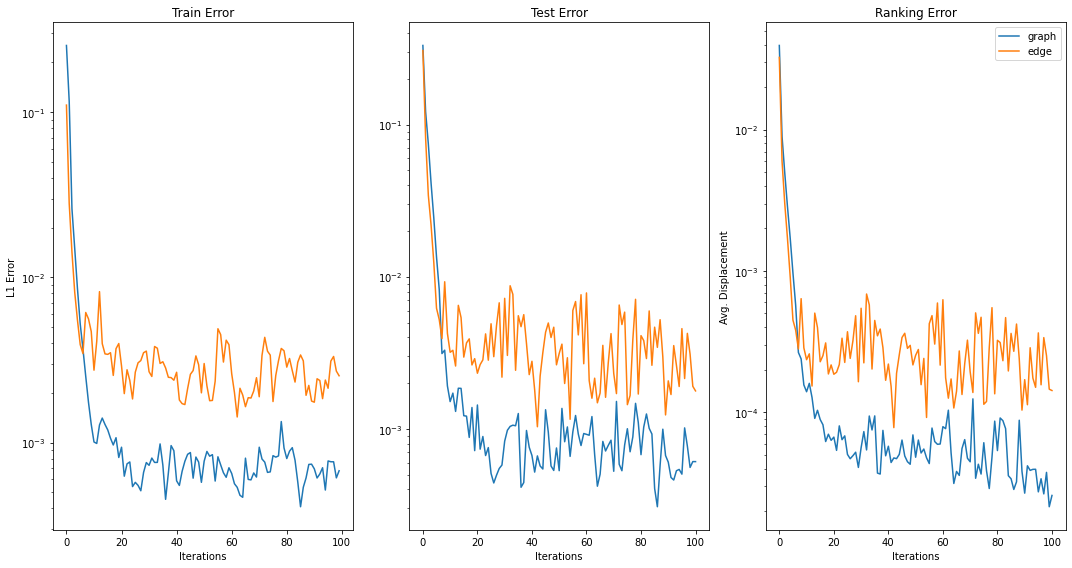

In [11]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.semilogy(graph_metrics[0])
plt.semilogy(edge_metrics[0])
plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
plt.semilogy(graph_metrics[1])
plt.semilogy(edge_metrics[1])
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
plt.semilogy(graph_metrics[2],label='graph')
plt.semilogy(edge_metrics[2],label='edge')
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

### Overview

GraphConv generally converges to around $7e^{-4}$, with EdgeConv averaging $2e^{-3}$. Seperation is greatest for weighted, directed case, followed by unweighted, undirected. As degree is arguably the simplest centrality measure, we should expect these models to perform no better on more complex centralities. Note: rank displacement is ill-suited to the unweighted, undirected case. There are only a limited number of values which $d_{degree}$ can take on, and few are unique. Hence small perturbations in our predictions have outsized effects on the displacement. 